# Keras-Image-Classification

## Divide OASIS Image datset into :


In [2]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt



import tensorflow as tf
from keras import backend as K
from shutil import copyfile
from shutil import rmtree

from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GRU, Bidirectional, LSTM
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Masking
from keras.layers.core import  ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.utils import multi_gpu_model
from keras import regularizers
from keras.regularizers import L1L2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import keras
from sklearn.model_selection import KFold
import os
import io
import numpy as np
import tensorflow as tf
from gensim.models import word2vec
import pandas as pd
# from fastText import load_model
from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing import text
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time

from os import listdir
from os.path import isfile, join
from shutil import copyfile
from shutil import rmtree
from sklearn.model_selection import StratifiedKFold
import glob
%matplotlib inline 

import pprint
os.environ["CUDA_VISIBLE_DEVICES"]="1"



# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 2
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

# fix random seed for reproducibility
seed = 7

None


## Data pre-processing and data augmentation

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html 

These are just a few of the options available (for more, see the documentation). Let's quickly go over what we just wrote:

- rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- shear_range is for randomly applying shearing transformations
- zoom_range is for randomly zooming inside pictures
- horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Now let's start generating some pictures using this tool and save them to a temporary directory, so we can get a feel for what our augmentation strategy is doing --we disable rescaling in this case to keep the images displayable:

Total Augmented images 21


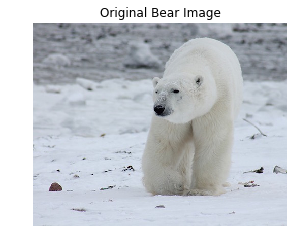

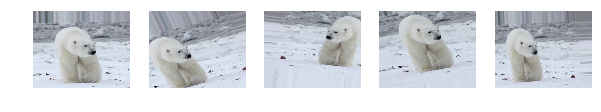

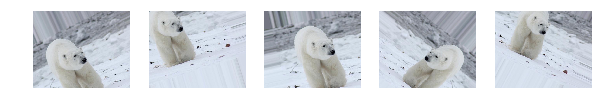

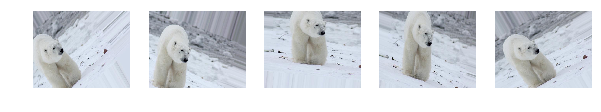

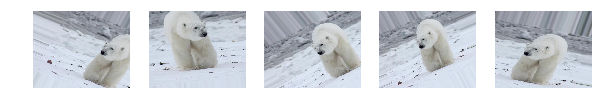

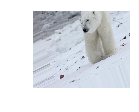

In [3]:
images_path = "/home/elkhand/git-repos/human-emotions-classifier/dataset/images/"
bear_image_path = images_path + "Bear 3.jpg"

augmented_images_path = "/home/elkhand/git-repos/human-emotions-classifier/preview/"

augmented_image_files = glob.glob(augmented_images_path+'*')
for f in augmented_image_files:
    os.remove(f)

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img(bear_image_path)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='Bear 3', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
        
pt.grid_display([bear_image_path],list_of_titles=["Original Bear Image"], figsize=(10,10))        

previewAugmentedBearImages = [augmented_images_path+f for f in listdir(augmented_images_path) if isfile(join(augmented_images_path, f))]  
pt.grid_display(previewAugmentedBearImages, no_of_columns=5)

print("Total Augmented images", len(previewAugmentedBearImages))

# 1st : Simple ConvNet model

## TODO: 
- Maybe make it classify 3 classes, instead of 2

Train size:  809
Val size:  91
Train label distribution:  {'neutral': 378, 'positive': 285, 'negative': 146}
Val label distribution:  {'positive': 32, 'negative': 17, 'neutral': 42}
all_images_dir dataset/images/
outputDir dataset/grouped/
groupName train
dataset/grouped//train/negative 	 146
dataset/grouped//train/neutral 	 378
dataset/grouped//train/positive 	 285
all_images_dir dataset/images/
outputDir dataset/grouped/
groupName val
dataset/grouped//val/negative 	 17
dataset/grouped//val/neutral 	 42
dataset/grouped//val/positive 	 32
params:  False 16 /home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/train /home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/val 224 224
Found 809 images belonging to 3 classes.
Found 91 images belonging to 3 classes.
validation_generator.class_indices {'negative': 0, 'neutral': 1, 'positive': 2}
num_classes 3
_________________________________________________________________
Layer (type)                 Output Shape     

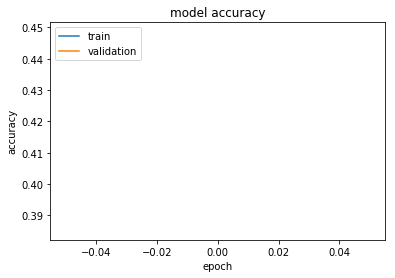

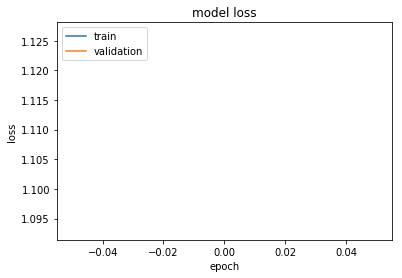

Train size:  809
Val size:  91
Train label distribution:  {'neutral': 378, 'positive': 285, 'negative': 146}
Val label distribution:  {'negative': 17, 'neutral': 42, 'positive': 32}
all_images_dir dataset/images/
outputDir dataset/grouped/
groupName train
dataset/grouped//train/negative 	 146
dataset/grouped//train/neutral 	 378
dataset/grouped//train/positive 	 285
all_images_dir dataset/images/
outputDir dataset/grouped/
groupName val
dataset/grouped//val/negative 	 17
dataset/grouped//val/neutral 	 42
dataset/grouped//val/positive 	 32
params:  False 16 /home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/train /home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/val 224 224
Found 809 images belonging to 3 classes.
Found 91 images belonging to 3 classes.
validation_generator.class_indices {'negative': 0, 'neutral': 1, 'positive': 2}
num_classes 3
_________________________________________________________________
Layer (type)                 Output Shape     

KeyboardInterrupt: 

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LeakyReLU, Activation, Dropout, Flatten, Dense


def build_model_vgg16(isBinaryClassification, num_classes, img_height, img_width):
    #Epoch 1/1 937/937 [==============================] - 176s 188ms/step - 
    #loss: 1.0401 - acc: 0.4663 - val_loss: 1.0382 - val_acc: 0.4650
    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_height, img_width)
    else:
        input_shape = (img_height, img_width, 3)
        
    model = Sequential()
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=input_shape ))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
    
    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
              
    # Block 4          
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
    
    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))
    
    # Classification block
    model.add(Flatten(name='flatten'))
    model.add(Dense(4096, activation='relu', name='fc1'))
    model.add(Dense(4096, activation='relu', name='fc2'))
    #model.add(Dense(classes, activation='softmax', name='predictions'))
    if isBinaryClassification:
        loss = 'binary_crossentropy'
        model.add(Dense(1, activation='sigmoid', name='predictions'))
    else:
        model.add(Activation('softmax'))
        loss = 'categorical_crossentropy'
        model.add(Dense(num_classes, activation='softmax', name='predictions'))

    model.compile(loss=loss,
                  optimizer='adam', #'rmsprop'
                  metrics=['accuracy'])
    print(model.summary())   
    return model
    

def build_model(isBinaryClassification, num_classes, img_height, img_width):
    
    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_height, img_width)
    else:
        input_shape = (img_height, img_width, 3)
    
    model = Sequential()
    model.add(Conv2D(filters=96, kernel_size=(3, 3), input_shape=input_shape))
    #model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=48, kernel_size=(3, 3), input_shape=input_shape))
    #model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3)))
    #model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3)))
    #model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(16, (3, 3)))
    #model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # the model so far outputs 3D feature maps (height, width, features)
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    
    
    if isBinaryClassification:
        loss = 'binary_crossentropy'
        model.add(Dense(1, activation='sigmoid'))
    else:
        loss = 'categorical_crossentropy'
        model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=loss,
                  optimizer='adam', #'rmsprop'
                  metrics=['accuracy'])
    print(model.summary())   
    return model

def train(isBinaryClassification, batch_size, trainDir, valDir, img_height, img_width, epochs): 
    print("params: ",isBinaryClassification, batch_size, trainDir, valDir, img_height, img_width)
    # this is the augmentation configuration we will use for training   
    train_datagen = ImageDataGenerator(
        #preprocessing_function=preprocess_input,
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    #         featurewise_center=True,
#         featurewise_std_normalization=True,
    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    #train_datagen.fit(x_train)
    
    # this is the augmentation configuration we will use for testing:
    # only rescaling
    #test_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(
        #preprocessing_function=preprocess_input,
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    
    if isBinaryClassification:
        class_mode='binary'
    else:
        class_mode='categorical'
    
    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            trainDir,  # this is the target directory
            target_size=(img_height, img_width),  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode=class_mode)  # since we use binary_crossentropy loss, we need binary labels
    

    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            valDir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode=class_mode)
    #class_mode='categorical'
    
    print("validation_generator.class_indices", validation_generator.class_indices)
#     print("validation_generator.classes", validation_generator.classes)
#     print("validation_generator.filenames", validation_generator.filenames)
    
    num_classes = len(train_generator.class_indices.keys())
    print("num_classes",num_classes)
    model = build_model(isBinaryClassification, num_classes, img_height, img_width)
    #model = build_model_vgg16(isBinaryClassification, num_classes, img_height, img_width)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.2, 
                                      patience=5, 
                                      min_lr=0.001)
    filepath="img_model/weights.best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)    
    callbacks_list = [ checkpoint, early_stopping, reduce_lr]  #
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=15000 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=1000 // batch_size,
        shuffle=True,
        callbacks=callbacks_list)
    
    
    val_acc_list = history.history['val_acc']
    best_val_acc =  max(val_acc_list)
    print("best_val_acc: ", best_val_acc)
    filename = "hec" 
    filename = "model/" + dt.generate_model_name(filename, best_val_acc) + ".h5"
    os.rename(filepath, filename)
    
    return history

batch_size = 16  
isBinaryClassification = False
neutralLow = 3.0
neutralHigh = 5.0
kfold_splits = 10
hasF1 = False
img_height = 224
img_width = 224
epochs = 1

oasis_csv_path = "dataset/metadata/OASIS.csv"
oasis_images_src = "dataset/images/"
dataset_path = "dataset/grouped/"
dataset_groups=["train", "val"]
classes = ["negative", "neutral", "positive"]

image_names, image_labels = dt.get_image_name_and_label(oasis_csv_path, neutralLow, neutralHigh)
image_names = np.array(image_names)
image_labels = np.array(image_labels)
# print("image_names[:10]",image_names[:10])
# print("\n","image_labels[:10]",image_labels[:10])

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
cv_accuracies = []
cv_f1s = []

X = image_names
y = image_labels
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
    print("Train size: ", len(train_indices))
    print("Val size: ", len(val_indices))
    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]
    print("Train label distribution: ", pt.get_label_count(y_train))
    print("Val label distribution: ", pt.get_label_count(y_val))
    dt.create_cross_validation_train_val("train", oasis_images_src, dataset_path, X_train, y_train)
    dt.create_cross_validation_train_val("val", oasis_images_src, dataset_path, X_val, y_val)


    if isBinaryClassification:
        for groupName in dataset_groups:
            neutralPath = dataset_path + "/" + groupName + "/" + "neutral"
            rmtree(neutralPath, ignore_errors=True)
        
    
    trainDir = "/home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/train"
    valDir = "/home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/val"

    history = train(isBinaryClassification, batch_size, trainDir, valDir, img_height, img_width, epochs)
    #pt.plot_model_accuracy(history, "img_model/",hasF1)
    best_val_acc = max(history.history['val_acc'])
    cv_accuracies.append(best_val_acc)
    if hasF1:
        best_val_f1 = max(history.history['val_f1'])
        cv_f1s.append(best_val_f1)
        
print("=========================================")
print("Cross-validation val accuracy results: " , cv_accuracies)
print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))

if hasF1:
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))        

# Transfer Learning with Keras

## Useful links 
- https://keras.io/applications/
- https://github.com/spejss/Keras-Transfer-Learning-Tutorial
    - https://github.com/spejss/Keras-Transfer-Learning-Tutorial/blob/master/3%20transfer_learning.py 
    

In [ ]:
# https://github.com/DeepLearningSandbox/DeepLearningSandbox/tree/master/transfer_learning

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
      Args:
        base_model: keras model excluding top
        nb_classes: # of classes
      Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
    predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    model = Model(input=base_model.input, output=predictions)
    return model


def setup_to_finetune(model):
    """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.
  note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch
  Args:
    model: keras model
    """
    for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
        layer.trainable = True
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


def train(isBinaryClassification, batch_size, trainDir, valDir, img_height, img_width, epochs): 
    """Use transfer learning and fine-tuning to train a network on a new dataset"""
    print("params: ",isBinaryClassification, batch_size, trainDir, valDir, img_height, img_width)
      
    nb_train_samples = get_nb_files(trainDir)
    nb_classes = len(glob.glob(trainDir + "/*"))
    nb_val_samples = get_nb_files(valDir)
    nb_epoch = epochs
    print("nb_train_samples",nb_train_samples)
    print("nb_classes",nb_classes)
    print("nb_val_samples",nb_val_samples)
    print("nb_epoch",nb_epoch)
    
    # data prep
    train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
    )
    test_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
    )
    
    
#     # this is the augmentation configuration we will use for training   
#     train_datagen = ImageDataGenerator(
#         #preprocessing_function=preprocess_input,
#         rescale=1./255,
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

    
#     # this is the augmentation configuration we will use for testing:
#     # only rescaling
#     #test_datagen = ImageDataGenerator(rescale=1./255)
#     test_datagen = ImageDataGenerator(
#         #preprocessing_function=preprocess_input,
#         rescale=1./255,
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')
    
    
    if isBinaryClassification:
        class_mode='binary'
    else:
        class_mode='categorical'
    
    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            trainDir,  # this is the target directory
            target_size=(img_height, img_width),  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode=class_mode)  # since we use binary_crossentropy loss, we need binary labels
    

    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            valDir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode=class_mode)
    
    print("validation_generator.class_indices", validation_generator.class_indices)

    
    num_classes = len(train_generator.class_indices.keys())
    print("num_classes",num_classes)
    # setup model
    base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
    model = add_new_last_layer(base_model, nb_classes)

    # transfer learning
    setup_to_transfer_learn(model, base_model)

    history_tl = model.fit_generator(
        train_generator,
        nb_epoch=nb_epoch,
        samples_per_epoch=nb_train_samples,
        validation_data=validation_generator,
        nb_val_samples=nb_val_samples,
        class_weight='auto')

    # fine-tuning
    setup_to_finetune(model)

    history_ft = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_val_samples,
        class_weight='auto')

    model.save(args.output_model_file)
    plot_training(history_ft)
    return history_ft





isBinaryClassification = False
hasF1 = False
batch_size = 32  
NB_IV3_LAYERS_TO_FREEZE = 172
neutralLow = 3.0
neutralHigh = 5.0
kfold_splits = 5
img_height = 299
img_width = 299
epochs = 3


# ===========
IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for InceptionV3
NB_EPOCHS = 3
BAT_SIZE = 32
FC_SIZE = 1024
NB_IV3_LAYERS_TO_FREEZE = 172
# ===========

oasis_csv_path = "dataset/metadata/OASIS.csv"
oasis_images_src = "dataset/images/"
dataset_path = "dataset/grouped/"
dataset_groups=["train", "val"]
classes = ["negative", "neutral", "positive"]

image_names, image_labels = dt.get_image_name_and_label(oasis_csv_path, neutralLow, neutralHigh)
image_names = np.array(image_names)
image_labels = np.array(image_labels)
# print("image_names[:10]",image_names[:10])
# print("\n","image_labels[:10]",image_labels[:10])

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
cv_accuracies = []
cv_f1s = []

X = image_names
y = image_labels


for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
    print("Train size: ", len(train_indices))
    print("Val size: ", len(val_indices))
    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]
    print("Train label distribution: ", pt.get_label_count(y_train))
    print("Val label distribution: ", pt.get_label_count(y_val))
    dt.create_cross_validation_train_val("train", oasis_images_src, dataset_path, X_train, y_train)
    dt.create_cross_validation_train_val("val", oasis_images_src, dataset_path, X_val, y_val)

    if isBinaryClassification:
        for groupName in dataset_groups:
            neutralPath = dataset_path + "/" + groupName + "/" + "neutral"
            rmtree(neutralPath, ignore_errors=True)


    trainDir = "/home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/train"
    valDir = "/home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/val"

    history = train(isBinaryClassification, batch_size, trainDir, valDir, img_height, img_width, epochs)

    #pt.plot_model_accuracy(history, "img_model/",hasF1)
    best_val_acc = max(history.history['val_acc'])
    cv_accuracies.append(best_val_acc)
    if hasF1:
        best_val_f1 = max(history.history['val_f1'])
        cv_f1s.append(best_val_f1)

print("=========================================")
print("Cross-validation val accuracy results: " , cv_accuracies)
print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))

if hasF1:
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))       

   

Train size:  719
Val size:  181
Train label distribution:  {'neutral': 336, 'positive': 253, 'negative': 130}
Val label distribution:  {'neutral': 84, 'negative': 33, 'positive': 64}
all_images_dir dataset/images/
outputDir dataset/grouped/
groupName train
dataset/grouped//train/positive 	 253
dataset/grouped//train/negative 	 130
dataset/grouped//train/neutral 	 336
all_images_dir dataset/images/
outputDir dataset/grouped/
groupName val
dataset/grouped//val/positive 	 64
dataset/grouped//val/negative 	 33
dataset/grouped//val/neutral 	 84
params:  False 32 /home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/train /home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/val 299 299
nb_train_samples 719
nb_classes 3
nb_val_samples 181
nb_epoch 3
Found 719 images belonging to 3 classes.
Found 181 images belonging to 3 classes.
validation_generator.class_indices {'negative': 0, 'neutral': 1, 'positive': 2}
num_classes 3


In [ ]:
def build_model_inception_v3():
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)
    #base_model = InceptionResNetV2(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(3, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, base_model


def train(isBinaryClassification, batch_size, trainDir, valDir, img_height, img_width, epochs): 
    print("params: ",isBinaryClassification,shouldTrainInceptionBlocks, batch_size, trainDir, valDir, img_height, img_width)
    # this is the augmentation configuration we will use for training   
    train_datagen = ImageDataGenerator(
        #preprocessing_function=preprocess_input,
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    
    # this is the augmentation configuration we will use for testing:
    # only rescaling
    #test_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(
        #preprocessing_function=preprocess_input,
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    
    if isBinaryClassification:
        class_mode='binary'
    else:
        class_mode='categorical'
    
    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            trainDir,  # this is the target directory
            target_size=(img_height, img_width),  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode=class_mode)  # since we use binary_crossentropy loss, we need binary labels
    

    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            valDir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode=class_mode)
    
    print("validation_generator.class_indices", validation_generator.class_indices)

    
    num_classes = len(train_generator.class_indices.keys())
    print("num_classes",num_classes)
    #model = build_model(isBinaryClassification, num_classes, img_height, img_width)
    #model = build_model_vgg16(isBinaryClassification, num_classes, img_height, img_width)
    model, base_model = build_model_inception_v3()
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.2, 
                                      patience=5, 
                                      min_lr=0.001)
    filepath="img_model/image.weights.best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)    
    callbacks_list = [ checkpoint, early_stopping, reduce_lr]  #
    print("\n=================================================\n")
    print("Training our added the last dense layer with Inception V3 model pre-trained weights")
    # train the model on the new data for a few epochs
    history = model.fit_generator(
            train_generator,
            steps_per_epoch= 5000 // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps= 1000 // batch_size,
            shuffle=True,
            callbacks=callbacks_list)

    val_acc_list = history.history['val_acc']
    best_val_acc =  max(val_acc_list)
    print("best_val_acc: ", best_val_acc)
    filename = "hec" 
    filename = "img_model/" + dt.generate_model_name(filename, best_val_acc) + \
                                        "-image-" + ".h5"
    os.rename(filepath, filename)
    
    print("\n=================================================\n")
    print("Training the last 2 inception blocks, and our added the last dense layer with Inception V3 model pre-trained weights")
    # at this point, the top layers are well trained and we can start fine-tuning
    # convolutional layers from inception V3. We will freeze the bottom N layers
    # and train the remaining top layers.

    # let's visualize layer names and layer indices to see how many layers
    # we should freeze:
    #for i, layer in enumerate(base_model.layers):
    #    print(i, layer.name)

    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 249 layers and unfreeze the rest:
    for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
        layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    from keras.optimizers import SGD
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

    # we train our model again (this time fine-tuning the top 2 inception blocks
    # alongside the top Dense layers
    # train the model on the new data for a few epochs
    history = model.fit_generator(
            train_generator,
            steps_per_epoch= 5000 // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=1000 // batch_size,
            shuffle=True,
            callbacks=callbacks_list)

    val_acc_list = history.history['val_acc']
    best_val_acc =  max(val_acc_list)
    print("best_val_acc: ", best_val_acc)
    filename = "hec" 
    filename = "img_model/" + dt.generate_model_name(filename, best_val_acc) + \
                                "-image-tuned-" + ".h5"
        os.rename(filepath, filename)
        print("\n=================================================\n")
    return history